In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import matplotlib.pyplot as plt

from spd.nathu_dev_utils import (
    aggregate_over,
    get_experiment_df,
    optimize_over,
    plot_metrics_by_group,
)



In [3]:
from spd.registry import EXPERIMENT_REGISTRY

wandb_project = 'spd'
run_ids = ['run_20250715_003802', 'run_20250715_184638']
dfs = {}
    
for exp_name in EXPERIMENT_REGISTRY.keys():
    try:
        df = get_experiment_df(
            sweep_run_id=run_ids,
            experiment_name=exp_name,
            project=wandb_project,
        )
        if not df.empty:
            dfs[exp_name] = df
    except Exception as e:
        print(f"Error: {exp_name} - {e}")

tms_5-2 - run_20250715_003802: 0it [00:00, ?it/s]
tms_5-2 - run_20250715_184638: 0it [00:00, ?it/s]
tms_5-2-id - run_20250715_003802: 100%|██████████| 40/40 [00:00<00:00, 11201.24it/s]
tms_5-2-id - run_20250715_184638: 0it [00:00, ?it/s]
tms_40-10 - run_20250715_003802: 0it [00:00, ?it/s]
tms_40-10 - run_20250715_184638: 0it [00:00, ?it/s]
resid_mlp3 - run_20250715_184638: 100%|██████████| 20/20 [00:00<00:00, 13229.16it/s]


In [4]:
opt_dfs = {}
for experiment_name, df in dfs.items():
    if len(df) == 0:
        continue
    opt_dfs[experiment_name] = optimize_over(df, 'summary.target_solution_error/total', 
                                             params=['config.importance_minimality_coeff'], 
                                             verbose=True, aggregate_cols=['config.seed'])

Aggregating over ['config.seed'] before optimization...
When config.p_anneal_start_frac=0.25: optimal params are importance_minimality_coeff=0.003 (summary.target_solution_error/total=1.7500)
When config.p_anneal_start_frac=1.0: optimal params are importance_minimality_coeff=0.003 (summary.target_solution_error/total=11.2500)

Returning 8 unaggregated runs with optimal parameters
(from 40 total runs)
Aggregating over ['config.seed'] before optimization...
When config.p_anneal_final_p=1.0, config.p_anneal_start_frac=0.25, config.pnorm=2: optimal params are importance_minimality_coeff=0.0001 (summary.target_solution_error/total=0.0000)
When config.p_anneal_final_p=1.0, config.p_anneal_start_frac=1.0, config.pnorm=2: optimal params are importance_minimality_coeff=0.0001 (summary.target_solution_error/total=0.0000)
When config.p_anneal_final_p=nan, config.p_anneal_start_frac=1.0, config.pnorm=1: optimal params are importance_minimality_coeff=0.0001 (summary.target_solution_error/total=0.00

/mnt/polished-lake/home/nhu/spd/spd/nathu_dev_utils.py:321: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  working_df.groupby(group_cols, dropna=False).apply(get_optimal_rows, include_groups=True).reset_index(drop=True)
/mnt/polished-lake/home/nhu/spd/spd/nathu_dev_utils.py:321: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  working_df.groupby(group_cols, dropna=False).apply(get_optimal_rows, include_groups=True).reset

In [46]:
def row_to_group_name(row):
    """
    Convert a row to a group name for plotting.
    """
    if row['config.p_anneal_start_frac'] == 0.25:
        return "P-Annealing"
    else:
        return f"P-Norm = {row['config.pnorm']}"

for df in opt_dfs.values():
    if len(df) == 0:
        continue
    df['group_name'] = df.apply(row_to_group_name, axis=1)

Plotting tms_5-2-id...


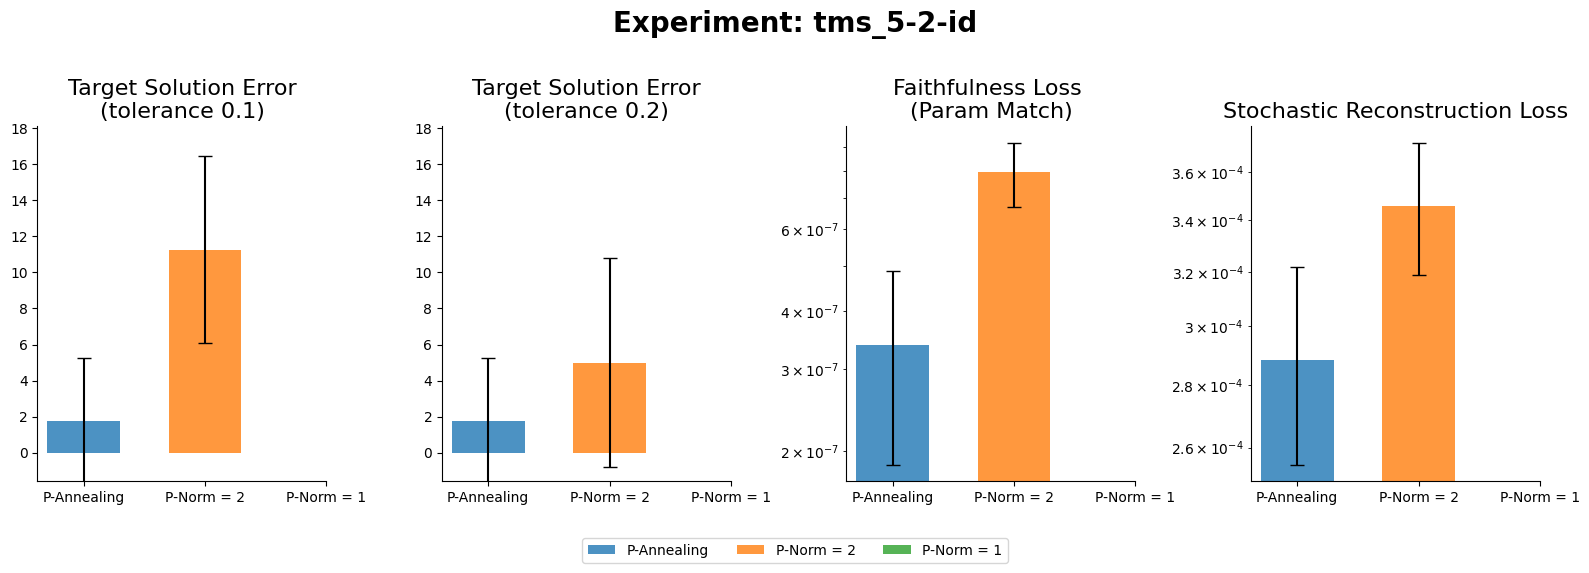

Plotting tms_40-10-id...


/tmp/ipykernel_3881721/1875500524.py:71: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(target_solution_ylims[0] * 0.9, target_solution_ylims[1] * 1.1)
/tmp/ipykernel_3881721/1875500524.py:71: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(target_solution_ylims[0] * 0.9, target_solution_ylims[1] * 1.1)


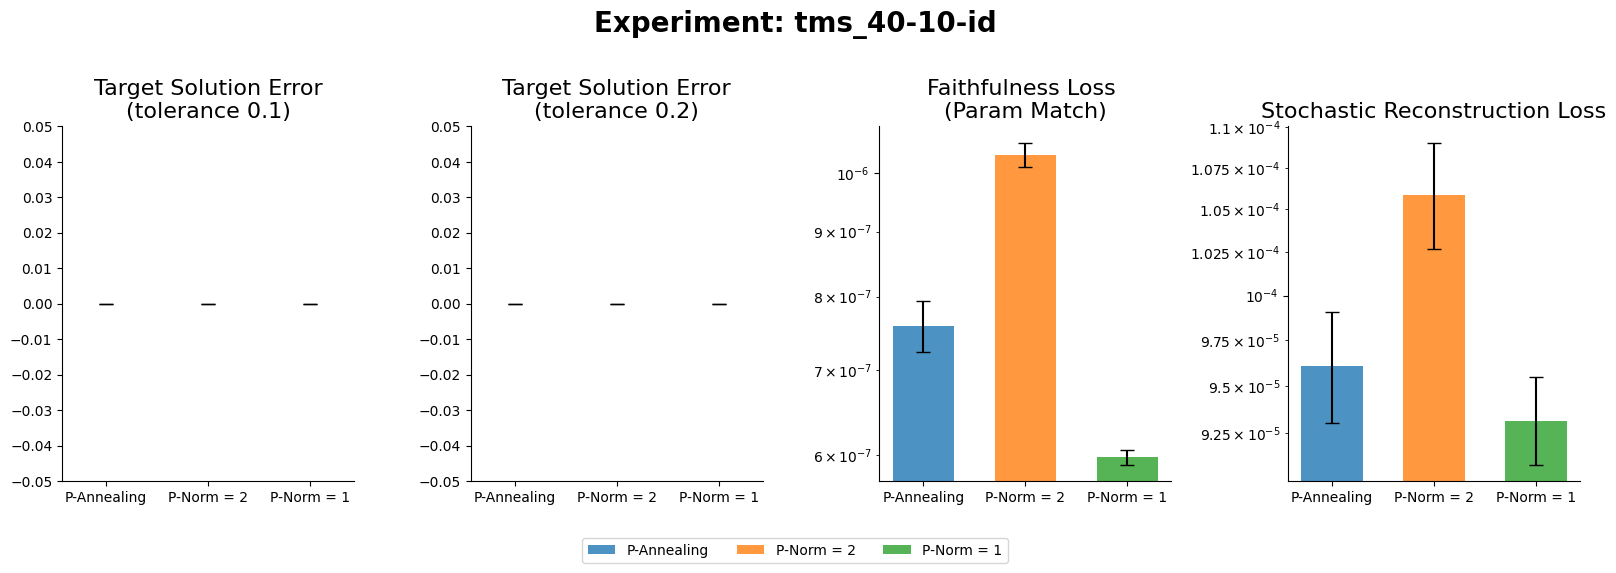

Plotting resid_mlp1...


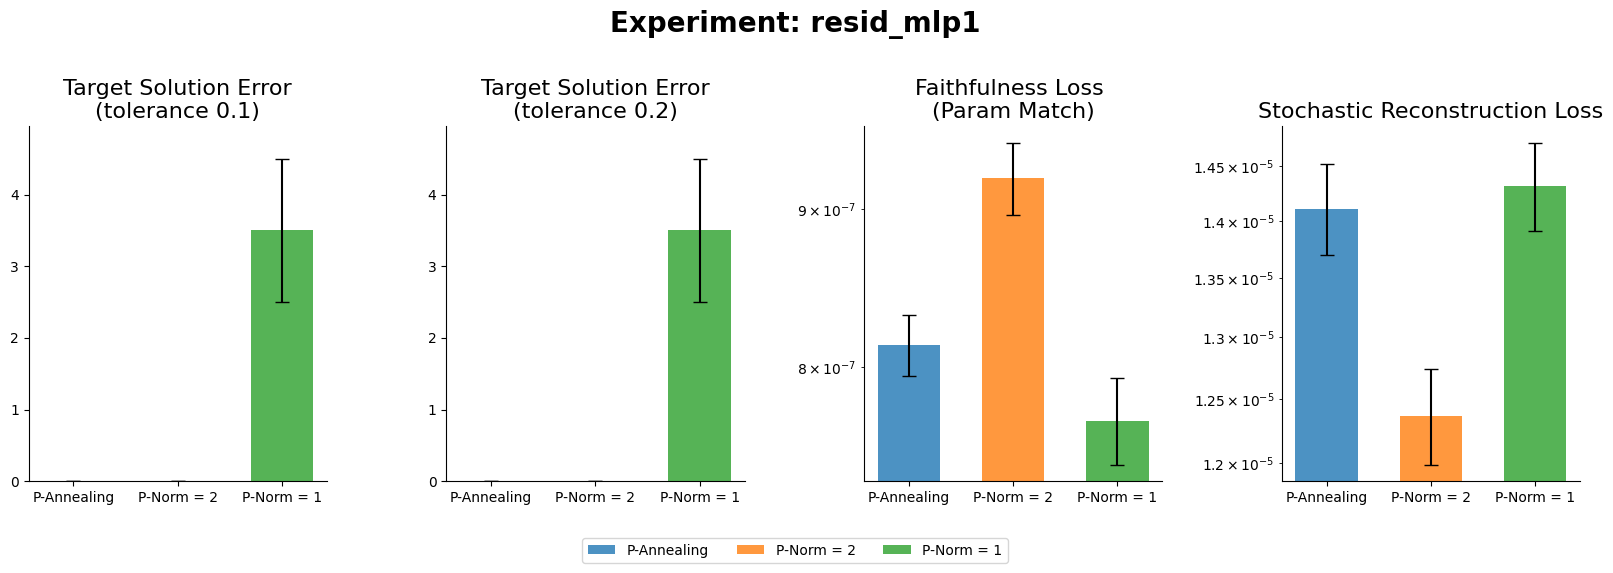

Plotting resid_mlp2...


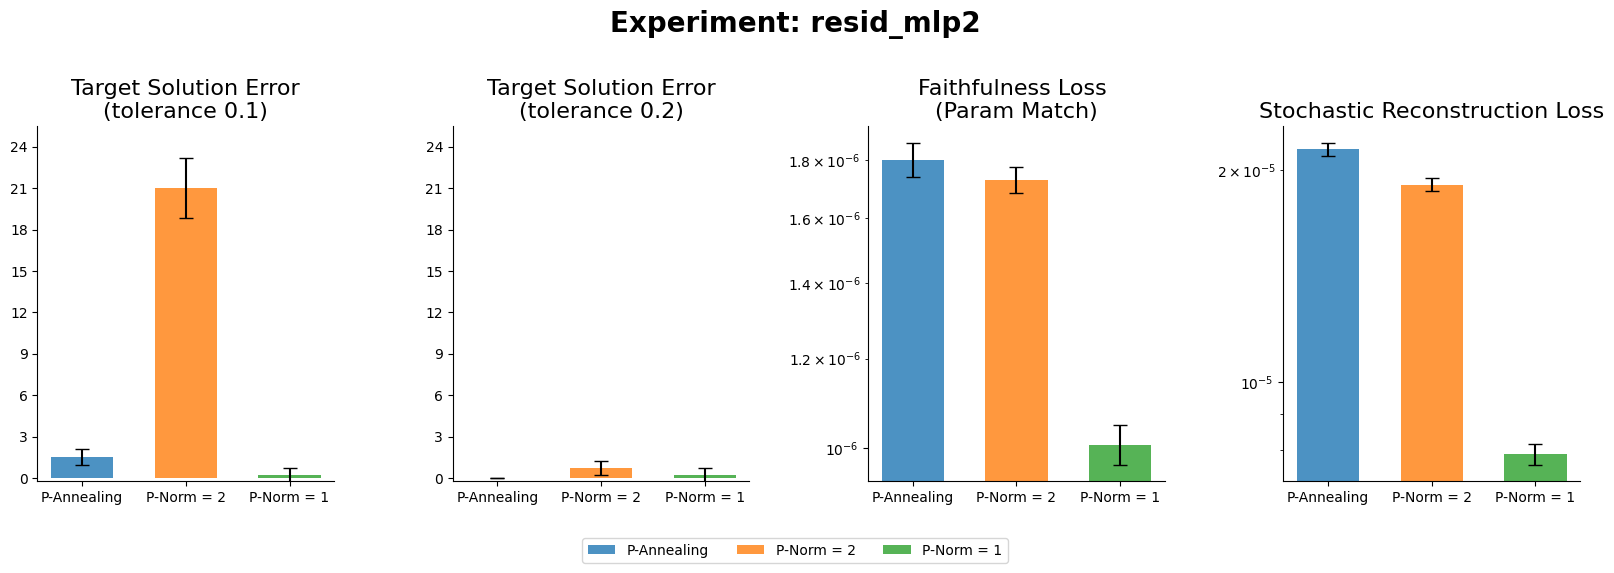

Plotting resid_mlp3...


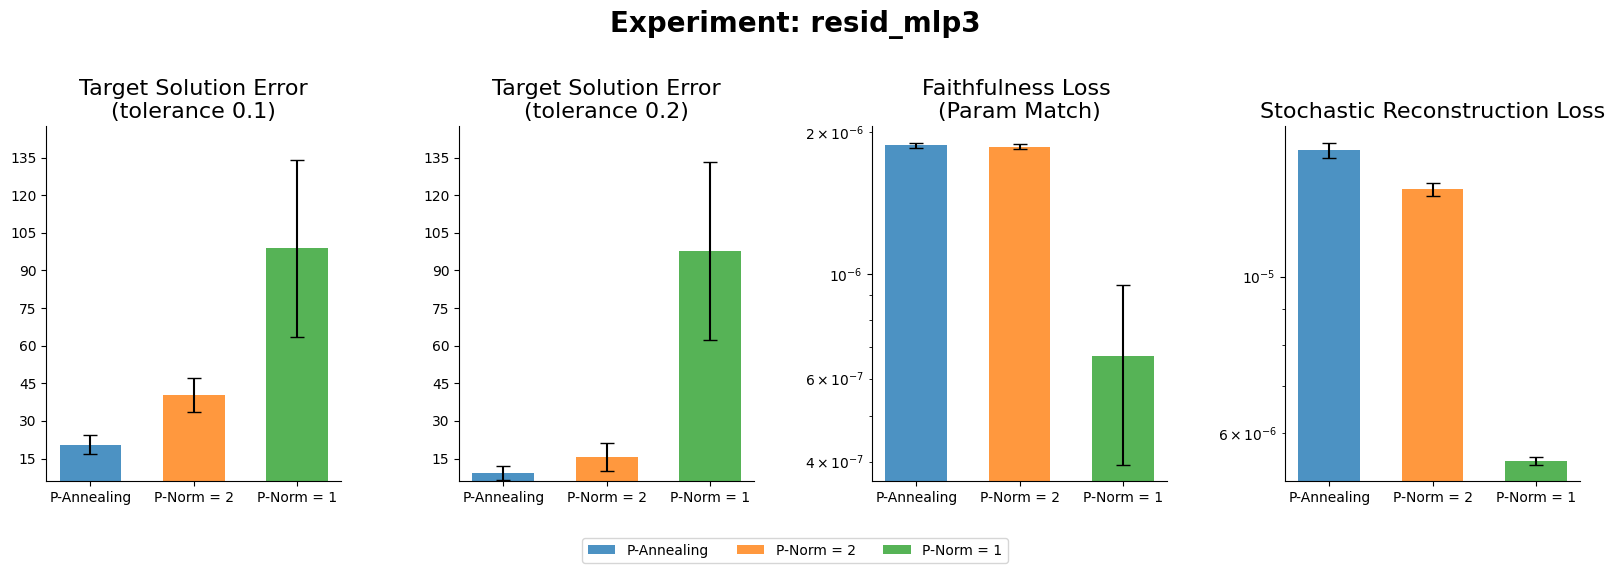

In [50]:

y_cols = {
    'summary.target_solution_error/total': "Target Solution Error\n(tolerance 0.1)",
    'summary.target_solution_error/total_0p2': "Target Solution Error\n(tolerance 0.2)",  
    'summary.loss/faithfulness': 'Faithfulness Loss \n(Param Match)',
    'summary.loss/stochastic_recon': "Stochastic Reconstruction Loss",
}

group_order = [ "P-Annealing", "P-Norm = 2", "P-Norm = 1",]

for experiment_name, df in opt_dfs.items():
    if len(df) == 0:
        continue
    print(f"Plotting {experiment_name}...")
    fig, axs = plot_metrics_by_group(df, y_cols, group_order=group_order,
                                     suptitle=f"Experiment: {experiment_name}")
    plt.show()


In [69]:
experiment_name = 'resid_mlp3'
agg_df = aggregate_over(dfs[experiment_name], 
                        aggregate_cols=['config.seed'])
agg_df['group_name'] = agg_df.apply(row_to_group_name, axis=1)

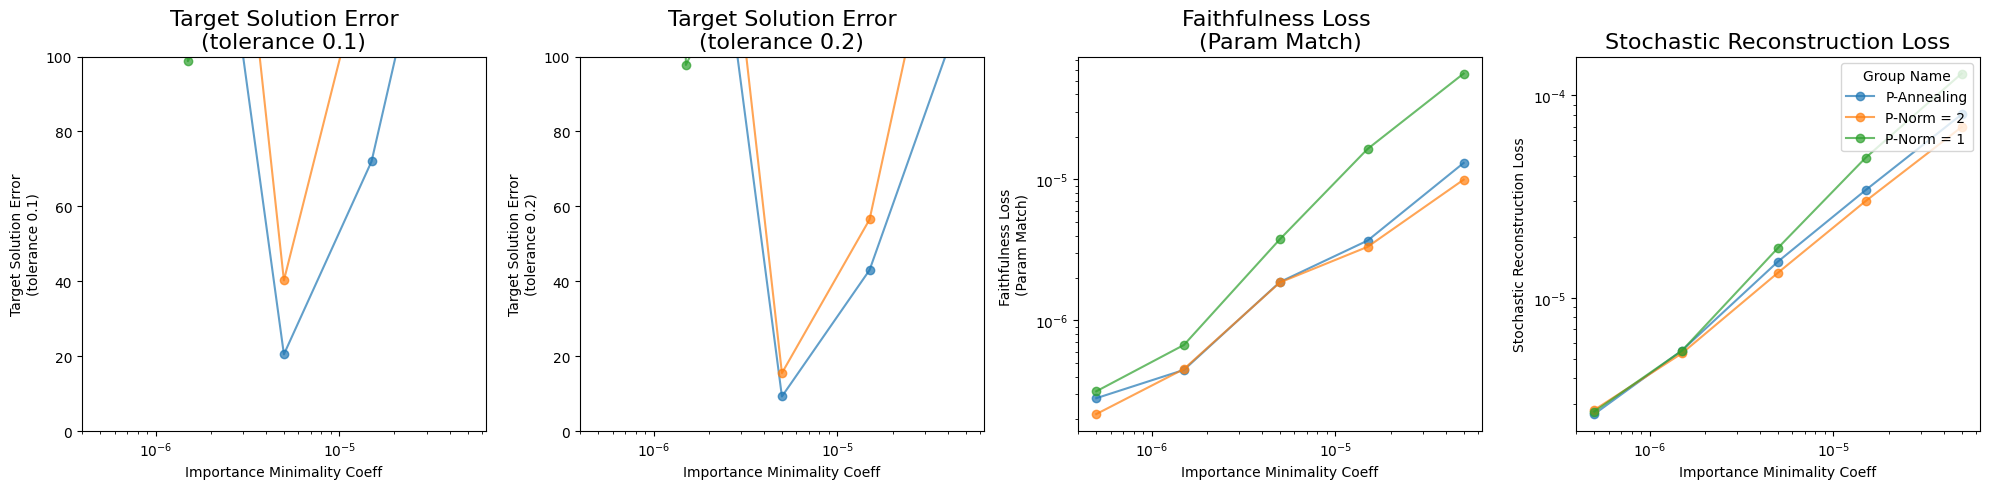

In [70]:
y_cols = {
    'summary.target_solution_error/total': "Target Solution Error\n(tolerance 0.1)",
    'summary.target_solution_error/total_0p2': "Target Solution Error\n(tolerance 0.2)",  
    'summary.loss/faithfulness': 'Faithfulness Loss \n(Param Match)',
    'summary.loss/stochastic_recon': "Stochastic Reconstruction Loss",
}

fig, axs = plt.subplots(
        nrows=1,
        ncols=len(y_cols),
        figsize=(5 * len(y_cols), 5),
    )

for i, (y_col, y_label) in enumerate(y_cols.items()):
    for group_name in agg_df['group_name'].unique():
        group_df = agg_df[agg_df['group_name'] == group_name]
        axs[i].plot(
            group_df['config.importance_minimality_coeff'], 
            group_df[y_col], 
            '-o',
            label=group_name, 
            alpha=0.7
        )
        axs[i].set_title(y_label, fontsize=16)
        axs[i].set_xlabel('Importance Minimality Coeff')
        axs[i].set_xscale('log')
        axs[i].set_ylabel(y_label)
        if 'loss' in y_col:
            axs[i].set_yscale('log')
        else:
            axs[i].set_ylim(0, 100)

axs[-1].legend(title='Group Name', loc='upper right', fontsize=10)
plt.tight_layout()
